In [1]:
#Import required libraries
import numpy as np
import os, math, csv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
import cv2

import tensorflow as tf
import keras.backend as K
from keras import initializers, layers, optimizers
from keras.layers import (Input,Conv2D,Activation,Dense,Flatten,Reshape,Dropout)
from keras.layers.merge import add
from keras.regularizers import l2
from keras.models import Model
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.utils.vis_utils import plot_model
from keras import callbacks
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score, classification_report, r2_score
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
K.clear_session()

Using TensorFlow backend.


In [2]:
class PickleImages(object):

    def __init__(self,PATH='', IMAGE_SIZE = 28): #Default image size set to 28 px
        self.PATH = PATH
        self.IMAGE_SIZE = IMAGE_SIZE
        self.image_data = []
        self.x_data = []
        self.y_data = []
        self.CATEGORIES = []
        self.list_categories = [] 

    def get_categories(self):
        for path in os.listdir(self.PATH):
            if '.DS_Store' in path:
                pass
            else:
                self.list_categories.append(path)
        print("Found Categories ",self.list_categories,'\n')
        return self.list_categories

    def Process_Image(self):
        try:
            self.CATEGORIES = self.get_categories()
            for categories in self.CATEGORIES:                                                  
                train_folder_path = os.path.join(self.PATH, categories)                         
                class_index = self.CATEGORIES.index(categories)                                 
                for img in os.listdir(train_folder_path):                                       
                    new_path = os.path.join(train_folder_path, img)                             
                    try:
                        image_data_temp = cv2.imread(new_path)                 # Read Image as numbers
                        image_temp_resize = cv2.resize(image_data_temp,(self.IMAGE_SIZE,self.IMAGE_SIZE))
                        self.image_data.append([image_temp_resize,class_index])
                    except:
                        pass
            data = np.asanyarray(self.image_data)

            # Iterate over the Data
            for x in data:
                self.x_data.append(x[0])        
                self.y_data.append(x[1])        
            X_Data = np.asarray(self.x_data)    
            Y_Data = np.asarray(self.y_data)
            # reshape x_Data as required! 
            #X_Data = X_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1)
            #Y_Data = Y_Data.reshape(-1, self.IMAGE_SIZE, self.IMAGE_SIZE, 1)
            return X_Data, Y_Data
        except:
            print("Failed to run Function Process Image ")

    def pickle_image(self):
        # Call the Function and Get the Data
        X_Data,Y_Data = self.Process_Image()
        # Write the Entire Data into a Pickle File
        pickle_out = open('X_Data','wb')
        pickle.dump(X_Data, pickle_out)
        pickle_out.close()
        # Write the Y Label Data
        pickle_out = open('Y_Data', 'wb')
        pickle.dump(Y_Data, pickle_out)
        pickle_out.close()

        print("Pickled Image Successfully ")
        return X_Data,Y_Data
    
    
    #If pickled imageset is available, rest of process doesn't get initiated! 
    def load_dataset(self):
        try:
            # Read the Data from Pickle Object
            X_Temp = open('X_Data','rb')
            X_Data = pickle.load(X_Temp)
            Y_Temp = open('Y_Data','rb')
            Y_Data = pickle.load(Y_Temp)
            print('Reading Dataset from Pickle Object')
            return X_Data,Y_Data

        except:
            print('Could not Found Pickle File ')
            print('Loading File and Dataset  ..........')
            X_Data,Y_Data = self.pickle_image()
            return X_Data,Y_Data

In [3]:
def make_confusion_matrix(cf, group_names=None, categories='auto', count=True, percent=True, cbar=True, xyticks=True,
                          xyplotlabels=True, sum_stats=False, figsize=None, cmap='Blues', title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

In [4]:
path = './ColonLungCancer' #Provide image path here!
a = PickleImages(PATH=path, IMAGE_SIZE=64) #Provide required image size
X_Data,Y_Data = a.load_dataset()

Reading Dataset from Pickle Object


In [5]:
print(X_Data.shape)
print(Y_Data.shape)

(25000, 64, 64, 3)
(25000,)


In [6]:
train_ratio = 0.6
validation_ratio = 0.2
test_ratio = 0.2
num_classes = 5

x_train, x_test, y_train, y_test = train_test_split(X_Data, Y_Data, test_size=1 - train_ratio, random_state = 123)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_val = x_val.astype('float32')
x_train /= 255.0 
x_test /= 255.0  
x_val /= 255.0 

y_true = y_test
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)

In [7]:
print(x_train.shape)
print(x_test.shape)
print(x_val.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(15000, 64, 64, 3)
(5000, 64, 64, 3)
(5000, 64, 64, 3)
(15000, 5)
(5000, 5)
(5000, 5)


In [8]:
def initializer():
    if not os.path.exists('results/'):
        os.mkdir('results')
    if not os.path.exists('weights/'):
        os.mkdir('weights')

def data_generator(x,y,batch_size):
    x_train,y_train = x,y
    from keras.preprocessing.image import ImageDataGenerator
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

    # Compute quantities required for featurewise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)
    generator = datagen.flow(x_train,y_train,batch_size=batch_size,shuffle=True)
    while True:
        x,y  = generator.next()
        yield ([x,y],[y,x])

In [9]:
class Length(layers.Layer):
    """
    Compute the length of vectors. This is used to compute a Tensor that has the same shape with y_true in margin_loss
    inputs: shape=[dim_1, ..., dim_{n-1}, dim_n]
    output: shape=[dim_1, ..., dim_{n-1}]
    """
    def call(self, inputs, **kwargs):
        return K.sqrt(K.sum(K.square(inputs), -1))

    def compute_output_shape(self, input_shape):
        return input_shape[:-1]

In [10]:
class Mask(layers.Layer):
    """
        Mask Tensor layer by the max value in first axis
        Input shape: [None,d1,d2]
        Output shape: [None,d2]
    """
    clip_value = (0,1)

    def Mask(self,clip_value=(0,1),**kwargs):
        self.clip_value = clip_value # what if clip value is not 0 and 1?

    def call(self,inputs,**kwargs):
        if type(inputs) is list:
            assert len(inputs) == 2
            inputs,mask = inputs
        else:
            x = inputs
            # enlarge range of values in x by mapping max(new_x) = 1, others 
            x = (x - K.max(x,1,True)) / K.epsilon() + 1
            mask = K.clip(x,self.clip_value[0],self.clip_value[1]) # clip value beween 0 and 1
        masked_input = K.batch_dot(inputs, mask, [1,1])
        return masked_input

    def compute_output_shape(self, input_shape):
        if type(input_shape[0]) is tuple:
            return tuple([None,input_shape[0][-1]])
    
        else:
            return tuple([None, input_shape[-1]])
        
def squash(vector, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vector), axis, keepdims=True)
    scale = s_squared_norm/(1+s_squared_norm)/K.sqrt(s_squared_norm)
    return scale*vector

In [11]:
class CapsuleLayer(layers.Layer):
    """
    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_vector] and output shape = \
    [None, num_capsule, dim_vector]. For Dense Layer, input_dim_vector = dim_vector = 1.
    
    :param num_capsule: number of capsules in this layer
    :param dim_vector: dimension of the output vectors of the capsules in this layer
    :param num_routings: number of iterations for the routing algorithm
    """
    def __init__(self, num_capsule, dim_vector, num_routing=3,
                 kernel_initializer='glorot_uniform',
                 bias_initializer='zeros',
                 **kwargs):
        super(CapsuleLayer, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_vector = dim_vector
        self.num_routing = num_routing
        self.kernel_initializer = initializers.get(kernel_initializer)
        self.bias_initializer = initializers.get(bias_initializer)

    def build(self,input_shape):
        assert len(input_shape) >= 3, "Input tensor must have shape=[None, input_num_capsule,input_dim_vector]"
        self.input_num_capsule = input_shape[1]
        self.input_dim_vector = input_shape[2]

        self.W = self.add_weight(shape=[self.input_num_capsule,self.num_capsule,self.input_dim_vector,self.dim_vector],
                                initializer=self.kernel_initializer,
                                name='W')
        self.bias = self.add_weight(shape=[1,self.input_num_capsule,self.num_capsule,1,1],
                                initializer=self.bias_initializer,
                                name='bias',trainable=False)
        self.built = True

    def call(self,inputs,training=None):
        # inputs.shape=[None, input_num_capsule, input_dim_vector]
        # Expand dims to [None, input_num_capsule, 1, 1, input_dim_vector]
        inputs_expand = K.expand_dims(K.expand_dims(inputs, 2), 2)

        # Replicate num_capsule dimension to prepare being multiplied by W
        # Now it has shape = [None, input_num_capsule, num_capsule, 1, input_dim_vector]
        inputs_tiled = K.tile(inputs_expand, [1, 1, self.num_capsule, 1, 1])

        """  
        # Compute `inputs * W` by expanding the first dim of W. More time-consuming and need batch_size.
        # Now W has shape  = [batch_size, input_num_capsule, num_capsule, input_dim_vector, dim_vector]
        w_tiled = K.tile(K.expand_dims(self.W, 0), [self.batch_size, 1, 1, 1, 1])
        
        # Transformed vectors, inputs_hat.shape = [None, input_num_capsule, num_capsule, 1, dim_vector]
        inputs_hat = K.batch_dot(inputs_tiled, w_tiled, [4, 3])
        """
        inputs_hat = tf.scan(lambda ac, x: K.batch_dot(x, self.W, [3, 2]),
                             elems=inputs_tiled,
                             initializer=K.zeros([self.input_num_capsule, self.num_capsule, 1, self.dim_vector]))

        assert self.num_routing > 0, 'The num_routing should be > 0.'
        for i in range(self.num_routing):
            c = tf.nn.softmax(self.bias, dim=2)  # dim=2 is the num_capsule dimension
            # outputs.shape=[None, 1, num_capsule, 1, dim_vector]
            outputs = squash(K.sum(c * inputs_hat, 1, keepdims=True))

            # last iteration needs not compute bias which will not be passed to the graph any more anyway.
            if i != self.num_routing - 1:
                # self.bias = K.update_add(self.bias, K.sum(inputs_hat * outputs, [0, -1], keepdims=True))
                self.bias += K.sum(inputs_hat * outputs, -1, keepdims=True)
            # tf.summary.histogram('BigBee', self.bias)  # for debugging

        return K.reshape(outputs, [-1, self.num_capsule, self.dim_vector])

    def compute_output_shape(self, input_shape):
        return tuple([None, self.num_capsule, self.dim_vector])

In [12]:
def PrimaryCap(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding,
                           name='primarycap_conv2d')(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector], name='primarycap_reshape')(output)
    return layers.Lambda(squash, name='primarycap_squash')(outputs)

In [13]:
def PrimaryCapsule(inputs, dim_vector, n_channels, kernel_size, strides, padding):
    """
    Apply Conv2D `n_channels` times and concatenate all capsules
    :param inputs: 4D tensor, shape=[None, width, height, channels]
    :param dim_vector: the dim of the output vector of capsule
    :param n_channels: the number of types of capsules
    :return: output tensor, shape=[None, num_capsule, dim_vector]
    """
    output = layers.Conv2D(filters=dim_vector*n_channels, kernel_size=kernel_size, strides=strides, padding=padding)(inputs)
    outputs = layers.Reshape(target_shape=[-1, dim_vector])(output)
    return layers.Lambda(squash)(outputs)

In [14]:
def convolution_block(input,kernel_size=8,filters=16,kernel_regularizer=l2(1.e-4)):
    conv2 = Conv2D(filters=filters,kernel_size=kernel_size,kernel_regularizer=kernel_regularizer,
                    kernel_initializer="he_normal",padding="same")(input)
    norm = BatchNormalization(axis=3)(conv2)
    activation = Activation("relu")(norm)
    return activation

In [15]:
def CapsNetv2(input_shape,n_class,n_route,n_prime_caps=8,dense_size = (16,32)):
    conv_filter = 32
    n_kernel = 8
    primary_channel =8
    primary_vector = 9
    capsule_dim_size = 9

    target_shape = input_shape

    input = Input(shape=input_shape)
    conv_block_1 = convolution_block(input,kernel_size=16,filters=32)
    primary_cap = PrimaryCapsule(conv_block_1,dim_vector=capsule_dim_size,n_channels=primary_channel,kernel_size=9,strides=2,padding='valid')    
    routing_layer = CapsuleLayer(num_capsule=n_class,dim_vector=capsule_dim_size*2,num_routing=n_route,name='routing_layer_1')(primary_cap)
    output = Length(name='output')(routing_layer)
    y = Input(shape=(n_class,))
    masked = Mask()([routing_layer,y])
    x_recon = Dense(dense_size[0],activation='relu')(masked)

    for i in range(1,len(dense_size)):
        x_recon = Dense(dense_size[i],activation='relu')(x_recon)
    x_recon = Dense(np.prod(target_shape),activation='relu')(x_recon)
    x_recon = Reshape(target_shape=target_shape,name='output_recon')(x_recon)
    return Model([input,y],[output,x_recon])

def margin_loss(y_true, y_pred):
    L = y_true * K.square(K.maximum(0., 0.9 - y_pred)) + \
        0.5 * (1 - y_true) * K.square(K.maximum(0., y_pred - 0.1))

    return K.mean(K.sum(L, 1))

def train(epochs=200,batch_size=64,mode=1):
    num_classes = 5
    model = CapsNetv2(input_shape=[64, 64, 3],
                        n_class=num_classes,
                        n_route=3)
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    model.summary()
    log = callbacks.CSVLogger('results/capsule-10Train_45Val_45Test'+str(num_classes)+'-log.csv')
    tb = callbacks.TensorBoard(log_dir='results/tensorboard-capsule-cifar-'+str(num_classes)+'-logs',
                               batch_size=batch_size, histogram_freq=True)
    checkpoint = callbacks.ModelCheckpoint('weights/capsule-10Train_45Val_45Test'+str(num_classes)+'.h5',
                                           save_best_only=True, save_weights_only=True, verbose=1)
    lr_decay = callbacks.LearningRateScheduler(schedule=lambda epoch: 0.001 * np.exp(-epoch / 10.))

    #plot_model(model, to_file='models/capsule-cifar-'+str(num_classes)+'.png', show_shapes=True)

    model.compile(optimizer=optimizers.adam(lr=0.1),
                  loss=[margin_loss, 'mse'],
                  loss_weights=[1., 0.1],
                  metrics={'output':'accuracy'})
    #from utils.helper_function import data_generator

    generator = data_generator(x_train,y_train,batch_size)
    # Image generator significantly increase the accuracy and reduce validation loss
    model.fit_generator(generator,
                        steps_per_epoch=x_train.shape[0] // batch_size,
                        validation_data=([x_val, y_val], [y_val, x_val]),
                        epochs=epochs, verbose=1, max_q_size=100,
                        callbacks=[log,checkpoint,lr_decay])


train(30, 64, 1)


Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
dim is deprecated, use axis instead
x_train shape: (15000, 64, 64, 3)
15000 train samples
5000 test samples
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 64, 64, 3)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 64, 64, 32)    24608       input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 64, 64, 32)    128        

C:\Users\Koushik\.conda\envs\cifardataset\lib\site-packages\ipykernel_launcher.py:62: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=234, validation_data=([array([[..., epochs=30, verbose=1, callbacks=[<keras.ca..., max_queue_size=100)`







Epoch 1/30
234/234 [==============================] - 198s - loss: 0.3332 - output_loss: 0.3143 - output_recon_loss: 0.1384 - output_acc: 0.5989 - val_loss: 0.9803 - val_output_loss: 0.9700 - val_output_recon_loss: 0.0530 - val_output_acc: 0.1966
Epoch 2/30
234/234 [==============================] - 198s - loss: 0.1716 - output_loss: 0.1634 - output_recon_loss: 0.0327 - output_acc: 0.7791 - val_loss: 0.4842 - val_output_loss: 0.4757 - val_output_recon_loss: 0.0363 - val_output_acc: 0.4474
Epoch 3/30
234/234 [==============================] - 196s - loss: 0.1472 - output_loss: 0.1392 - output_recon_loss: 0.0316 - output_acc: 0.8136 - val_loss: 0.2401 - val_output_loss: 0.2321 - val_output_recon_loss: 0.0320 - val_output_acc: 0.7282
Epoch 4/30
234/234 [==============================] - 201s - loss: 0.1327 - output_loss: 0.1248 - output_recon_loss: 0.0314 - output_acc: 0.8333 - val_loss: 0.3534 - val_output_loss: 0.3455 - val_output_recon_loss: 0.0311 - val_output_acc: 0.7594
Epoch 5

234/234 [==============================] - 186s - loss: 0.0489 - output_loss: 0.0417 - output_recon_loss: 0.0304 - output_acc: 0.9670 - val_loss: 0.1356 - val_output_loss: 0.1284 - val_output_recon_loss: 0.0312 - val_output_acc: 0.8342
Epoch 17/30
234/234 [==============================] - 189s - loss: 0.0457 - output_loss: 0.0385 - output_recon_loss: 0.0304 - output_acc: 0.9716 - val_loss: 0.0817 - val_output_loss: 0.0745 - val_output_recon_loss: 0.0305 - val_output_acc: 0.9194
Epoch 18/30
234/234 [==============================] - 197s - loss: 0.0410 - output_loss: 0.0339 - output_recon_loss: 0.0303 - output_acc: 0.9779 - val_loss: 0.0863 - val_output_loss: 0.0792 - val_output_recon_loss: 0.0304 - val_output_acc: 0.9090
Epoch 19/30
234/234 [==============================] - 197s - loss: 0.0373 - output_loss: 0.0302 - output_recon_loss: 0.0302 - output_acc: 0.9810 - val_loss: 0.0885 - val_output_loss: 0.0814 - val_output_recon_loss: 0.0304 - val_output_acc: 0.8856
Epoch 20/30
234/234 

In [16]:
model = CapsNetv2(input_shape=[64, 64, 3], n_class=5, n_route=3)
model.load_weights('weights/capsule-10Train_45Val_45Test5'+'.h5') 
print("Weights loaded, start validation")   
y_pred, x_recon = model.predict([x_test, y_test], batch_size=100)
print('-'*50)
print('Test acc:', np.sum(np.argmax(y_pred, 1) == np.argmax(y_test, 1))/y_test.shape[0])

Weights loaded, start validation
--------------------------------------------------
Test acc: 0.954


In [17]:
y_prediction = (y_pred > 0.8) 
y_prediction = np.argmax(y_pred, axis=1)

In [18]:
print('Confusion Matrix: ') 
print(confusion_matrix(y_true, y_prediction))

Confusion Matrix: 
[[ 918   68    3    0    0]
 [  33  953    0    0    0]
 [  12    0  953    4   54]
 [   0    0    7 1006    0]
 [   1    0   48    0  940]]


In [19]:
print('Precision Score: ' + str(precision_score(y_true, y_prediction, average='weighted')))
print('Recall score: ' + str(recall_score(y_true, y_prediction, average='weighted')))
print('F1 Score: ' + str(f1_score(y_true, y_prediction, average='weighted')))
print('Accuracy Score: ' + str(accuracy_score(y_true, y_prediction, normalize=True, sample_weight=None)))
print('R2 score: ' + str(r2_score(y_true, y_prediction,multioutput='variance_weighted')))
print('Classification Score: \n' + str(classification_report(y_true, y_prediction)))

Precision Score: 0.9541418846449847
Recall score: 0.954
F1 Score: 0.9539751872338488
Accuracy Score: 0.954
R2 score: 0.9398639120329305
Classification Score: 
              precision    recall  f1-score   support

           0       0.95      0.93      0.94       989
           1       0.93      0.97      0.95       986
           2       0.94      0.93      0.94      1023
           3       1.00      0.99      0.99      1013
           4       0.95      0.95      0.95       989

    accuracy                           0.95      5000
   macro avg       0.95      0.95      0.95      5000
weighted avg       0.95      0.95      0.95      5000



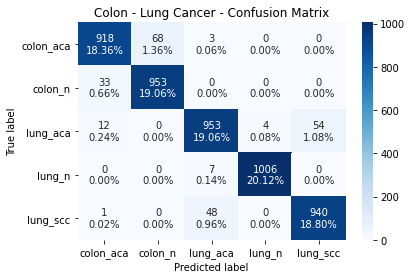

In [20]:
categories = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc']
make_confusion_matrix(confusion_matrix(y_true, y_prediction), categories = categories,sum_stats=False, title='Colon - Lung Cancer - Confusion Matrix')